In [1]:
import numpy as np
from helpers_HW.HW3.ion_trap import IonTrapEnv

class PSAgentDynamic:
    def __init__(self, gamma: float, eta: float, num_actions: int, init_h: float = 1.0):
        self.gamma = gamma
        self.eta = eta
        self.num_actions = num_actions
        self.init_h = init_h

        # Dynamisk mapping fra "state key" -> rad-indeks i tabellen
        self.state_to_idx = {}

        # Start med 0 stater; vi legger til etter hvert
        self.hmatrix = np.zeros((0, num_actions), dtype=float)
        self.gmatrix = np.zeros((0, num_actions), dtype=float)

    def _ensure_state(self, state_key):
        """Sørger for at state_key finnes i tabellen, ellers legg til ny rad."""
        if state_key in self.state_to_idx:
            return self.state_to_idx[state_key]

        new_idx = len(self.state_to_idx)
        self.state_to_idx[state_key] = new_idx

        # legg til ny rad i h og g
        h_row = np.full((1, self.num_actions), self.init_h, dtype=float)
        g_row = np.zeros((1, self.num_actions), dtype=float)

        self.hmatrix = np.vstack([self.hmatrix, h_row])
        self.gmatrix = np.vstack([self.gmatrix, g_row])

        return new_idx

    def reset_gmatrix(self):
        self.gmatrix[:] = 0.0

    def update_gmatrix(self):
        self.gmatrix *= (1.0 - self.eta)

    def learn(self, reward: float):
        # samme oppdatering som du hadde
        self.hmatrix = self.hmatrix - self.gamma * (self.hmatrix - 1.0) + self.gmatrix * reward

        # trygging: hold h positiv for å kunne normalisere til sannsynligheter
        self.hmatrix = np.clip(self.hmatrix, 1e-12, None)

    def _probs_from_h(self, s_idx: int):
        h = self.hmatrix[s_idx]
        Z = np.sum(h)
        if Z <= 0:
            return np.ones_like(h) / len(h)
        return h / Z

    def deliberate(self, state_key):
        s_idx = self._ensure_state(state_key)

        probs = self._probs_from_h(s_idx)
        action = np.random.choice(self.num_actions, p=probs)

        # glow
        self.update_gmatrix()
        self.gmatrix[s_idx, action] = 1.0

        return action

    def act(self, state_key, greedy: bool = False):
        s_idx = self._ensure_state(state_key)
        probs = self._probs_from_h(s_idx)
        return int(np.argmax(probs)) if greedy else int(np.random.choice(self.num_actions, p=probs))


def state_key_from_env(env, include_time: bool = True):
    """
    Lager en diskret state-representasjon fra miljøet.
    For IonTrapEnv er SRV en veldig naturlig kandidat.
    """
    srv = tuple(env.srv(env.state))  # env.srv(...) gir typisk en liste
    if include_time:
        return (srv, int(env.time_step))
    return srv


def train_ps_iontrap(env, gamma: float, eta: float, episodes: int, include_time_in_state: bool = True):
    agent = PSAgentDynamic(gamma=gamma, eta=eta, num_actions=env.num_actions)

    time_steps = []
    rewards = []

    for ep in range(episodes):
        env.reset()
        agent.reset_gmatrix()

        done = False
        r_final = 0.0

        while not done:
            skey = state_key_from_env(env, include_time=include_time_in_state)
            action = agent.deliberate(skey)

            _, r, done = env.step(action)
            agent.learn(r)

            r_final = r  # i dette miljøet er belønning typisk 0 eller 1, siste holder

        time_steps.append(env.time_step)
        rewards.append(r_final)

    return agent, time_steps, rewards


# --- Eksempelbruk (tilsvarer oppsettet ditt) ---
srv = [3, 3, 3]
KWARGS = {
    "phases": {"pulse_angles": [np.pi/2], "pulse_phases": [np.pi/2], "ms_phases": [-np.pi/2]},
    "num_ions": 3,
    "goal": [srv],
    "max_steps": 10,
}
env = IonTrapEnv(**KWARGS)

gamma = 1e-7
eta = 0.006

runs = 30
episodes = 500

all_steps, all_rewards = [], []
for _ in range(runs):
    agent, steps, rewards = train_ps_iontrap(env, gamma, eta, episodes, include_time_in_state=True)
    all_steps.append(steps)
    all_rewards.append(rewards)


Text(0.5, 1.0, 'Number of steps')

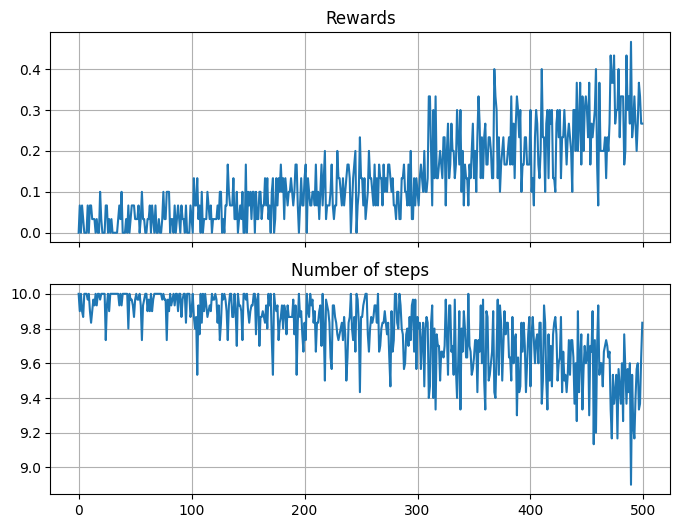

In [3]:
import matplotlib.pyplot as plt

avg_steps = np.mean(all_steps, 0)
avg_rewards = np.mean(all_rewards, 0)

f, axes = plt.subplots(2, sharex=True, figsize=(8, 6))
axes[0].plot(avg_rewards)
axes[0].grid()
axes[0].set_title('Rewards')
axes[1].plot(avg_steps)
axes[1].grid()
axes[1].set_title('Number of steps')

In [4]:
print(all_rewards, all_steps)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0